**Before you start:** Click **File → Save a copy in Drive** so you have your own version of this notebook. If you skip this step, your work will not be saved.

**Turn off AI assistance:** Go to **Settings → AI Assistance** and uncheck everything. AI-generated code is not allowed on assignments in this course.

# Load Modules

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

pd.options.display.max_columns = None
from sklearn.calibration import calibration_curve


from sklearn.linear_model import LinearRegression as ols
from sklearn.tree import DecisionTreeClassifier as dtc

from sklearn.linear_model import LogisticRegression as lr
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV as gs_CV


from sklearn.model_selection import cross_val_predict


In [2]:
def calibration_plot(y_true, y_prob, n_bins=10):
    """
    Create a calibration plot with a 45-degree dashed line.

    Parameters:
        y_true (array-like): True binary labels (0 or 1).
        y_prob (array-like): Predicted probabilities for the positive class.
        n_bins (int): Number of bins to divide the data for calibration.

    Returns:
        None
    """
    # Calculate calibration values
    bin_means, prob_true = calibration_curve(y_true, y_prob, n_bins=n_bins)
    
    # Create the Seaborn plot
    sns.set(style="whitegrid")
    plt.plot([0, y_prob.max()], [0, y_prob.max()], "k--")
    plt.plot(prob_true, bin_means, marker='o', label="Model")
    
    plt.xlabel("Mean Predicted Probability")
    plt.ylabel("Fraction of Positives")
    plt.title("Calibration Plot")
    plt.legend(loc="best")
    plt.show()

# Load Data


In [3]:
pred_universe = pd.read_csv('https://www.dropbox.com/s/ckhwdenrp6w7aef/universe_lab8.csv?dl=1')
pred_universe.rename(columns={'outcome_at_init' : 'judge_decision'}, inplace=True)
pred_universe.head()

,arrest_id,person_id,arrest_date,age_at_arrest,sex,judge_decision,fta
0,4204158,84307,2018-03-10,34.665753,F,HWOB,False
1,7045134,80682,2016-05-17,20.172603,M,HWOB,False
2,3720443,11591,2018-05-22,36.794521,M,HDOB,False
3,5222333,2026990,2017-09-10,21.024658,M,ROR,False
4,6096475,3211685,2017-02-19,65.958904,M,HWOB,False


In [4]:
pred_universe.judge_decision.value_counts()

judge_decision
ROR     4025
HDOB    3549
HWOB    2426
Name: count, dtype: int64

### Meaning of values in judge_decision column
- ROR - Release on recognizance
- HDOB - Held on bail (possible for defendant to be released if bail amount paid)
- HWOB - Held without bail (no possibility of release)

In [5]:
arrest_events = pd.read_csv('https://www.dropbox.com/scl/fi/41q9nvyrtf0hsfs2si1a1/arrest_events_lab8.csv?rlkey=9scrcgr65f3hgo26punp4qcso&dl=1')

In [6]:
arrest_events.head()

,person_id,arrest_id,arrest_date,charge_no,charge_degree,offense_category
0,908820,6330539,2016-12-15,5.0,misdemeanor,other
1,908820,6330539,2016-12-15,1.0,misdemeanor,drug
2,908820,6330539,2016-12-15,2.0,felony,drug
3,908820,6330539,2016-12-15,3.0,felony,drug
4,908820,6330539,2016-12-15,4.0,felony,other


# Create features
## Feature 1
We will first use `get_dummies` on pred_universe to one-hot encode `judge_decision` and use the features as predictors

In [7]:
pred_universe = pd.get_dummies(data=pred_universe, columns=['judge_decision'])
pred_universe.head()

,arrest_id,person_id,arrest_date,age_at_arrest,sex,fta,judge_decision_HDOB,judge_decision_HWOB,judge_decision_ROR
0,4204158,84307,2018-03-10,34.665753,F,False,False,True,False
1,7045134,80682,2016-05-17,20.172603,M,False,False,True,False
2,3720443,11591,2018-05-22,36.794521,M,False,True,False,False
3,5222333,2026990,2017-09-10,21.024658,M,False,False,False,True
4,6096475,3211685,2017-02-19,65.958904,M,False,False,True,False


## Feature 2
We will next use get_dummies on arrest_events to one-hot encode the charge_degree.

Note that this version of arrest_events has multiple charges per arrest. These are on separate rows.

Our goal is to create a dataframe where there is one arrest_id per row and the columns tells us the number of different charge degrees 

In [8]:
arrest_events = pd.get_dummies(data=arrest_events, columns=['charge_degree'])

In [9]:
arrest_events.head()

,person_id,arrest_id,arrest_date,charge_no,offense_category,charge_degree_felony,charge_degree_misdemeanor
0,908820,6330539,2016-12-15,5.0,other,False,True
1,908820,6330539,2016-12-15,1.0,drug,False,True
2,908820,6330539,2016-12-15,2.0,drug,True,False
3,908820,6330539,2016-12-15,3.0,drug,True,False
4,908820,6330539,2016-12-15,4.0,other,True,False


Next we will use groupby to add up the felony and misdemeanor chargers.

We use reset_index here so that `arrest_id` becomes a column (as opposed to the index) and will allow us to merge these features in with `pred_universe`.

In [10]:
charge_degrees = arrest_events.groupby(['arrest_id'])[
    ['charge_degree_felony', 'charge_degree_misdemeanor']
].sum().reset_index()
charge_degrees

,arrest_id,charge_degree_felony,charge_degree_misdemeanor
0,1615234,1,0
1,2462016,1,0
2,2466998,0,1
3,2468867,0,1
4,2468896,0,1
...,...,...,...
9995,12007194,1,0
9996,12007222,1,0
9997,12007337,2,4
9998,12007368,1,0


In [11]:
pred_universe = pred_universe.merge(charge_degrees, on=['arrest_id'])
pred_universe.head()

,arrest_id,person_id,arrest_date,age_at_arrest,sex,fta,judge_decision_HDOB,judge_decision_HWOB,judge_decision_ROR,charge_degree_felony,charge_degree_misdemeanor
0,4204158,84307,2018-03-10,34.665753,F,False,False,True,False,1,0
1,7045134,80682,2016-05-17,20.172603,M,False,False,True,False,2,8
2,3720443,11591,2018-05-22,36.794521,M,False,True,False,False,0,3
3,5222333,2026990,2017-09-10,21.024658,M,False,False,False,True,0,3
4,6096475,3211685,2017-02-19,65.958904,M,False,False,True,False,1,3


# Run GridSearchCV
First we will create the parameter grid for `C`

In [12]:
param_grid = {'C' : [.1, 1, 10]}

#### Then we wil will create a training and a test set. 

In [13]:
train, test = train_test_split(pred_universe, test_size=.5, shuffle=True, stratify=pred_universe['fta'])

#### Next, we will initialize the logistic regression model. 

In [14]:
lr_model = lr(max_iter=1000)

#### Now, we initialize the GridSearchCV instance.

In [15]:
gs = gs_CV(
    estimator = lr_model,
    param_grid = param_grid,
    cv=5
)

#### Create the list of predictive features we want to use

In [16]:
features = ['age_at_arrest', 
            'judge_decision_HDOB', 
            'judge_decision_HWOB',
            'judge_decision_ROR',
            'charge_degree_felony',
            'charge_degree_misdemeanor'] 

#### Run the model selection procedure

In [17]:
gs = gs.fit(X=train[features], y=train['fta'])

#### Look at which `C` value was chosen

In [18]:
gs.best_params_

{'C': 0.1}

# Predict for test set

In [19]:
test['pred_lr'] = gs.predict_proba(test[features])[:, 1]

### Plot the calibration curve

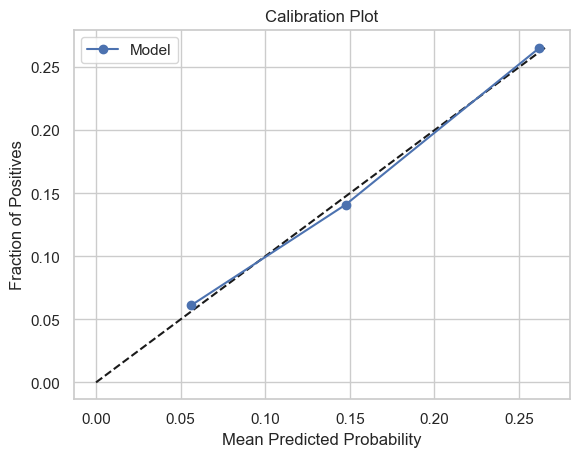

In [20]:
calibration_plot(y_true=test['fta'], y_prob=test['pred_lr'])

In [21]:
base_rate = train['fta'].mean()
base_rate


0.159

In [22]:
test['yhat_lr'] = test['pred_lr'] > base_rate

In [23]:
recall = test[test['fta']==1]['yhat_lr'].mean()
recall

0.614321608040201

In [24]:
precision = test[test['yhat_lr']==1]['fta'].mean()
precision

0.2532366649404454

# Nested CV

In [25]:
nested_gs = gs_CV(
    estimator = lr_model,
    param_grid = param_grid,
    cv=5
)

In [26]:
pred_universe['pred_lr'] = cross_val_predict(estimator=nested_gs, 
                 X=pred_universe[features],
                 y=pred_universe['fta'],
                  method='predict_proba',
                  cv=5
                     )[:, 1]

In [27]:
pred_universe

,arrest_id,person_id,arrest_date,age_at_arrest,sex,fta,judge_decision_HDOB,judge_decision_HWOB,judge_decision_ROR,charge_degree_felony,charge_degree_misdemeanor,pred_lr
0,4204158,84307,2018-03-10,34.665753,F,False,False,True,False,1,0,0.061842
1,7045134,80682,2016-05-17,20.172603,M,False,False,True,False,2,8,0.030909
2,3720443,11591,2018-05-22,36.794521,M,False,True,False,False,0,3,0.150649
3,5222333,2026990,2017-09-10,21.024658,M,False,False,False,True,0,3,0.253764
4,6096475,3211685,2017-02-19,65.958904,M,False,False,True,False,1,3,0.055676
...,...,...,...,...,...,...,...,...,...,...,...,...
9995,4667284,1238,2017-12-10,36.778082,M,False,False,True,False,3,3,0.023322
9996,6267500,2786496,2017-01-08,50.276712,M,False,False,True,False,1,0,0.056123
9997,7318046,11750,2016-03-23,33.961644,M,False,False,False,True,0,2,0.265696
9998,5738381,1750927,2017-05-24,71.473973,F,True,False,False,True,0,3,0.249720


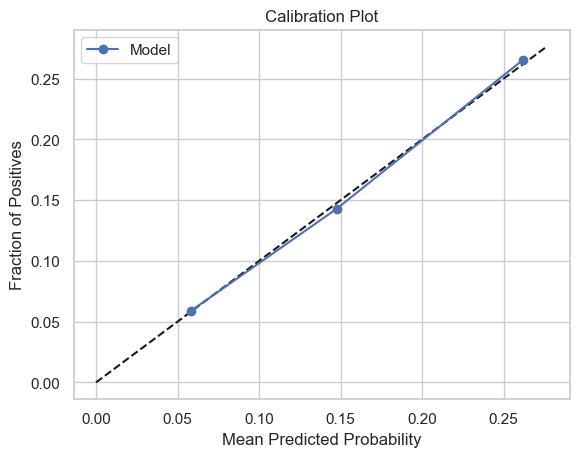

In [28]:
calibration_plot(y_true=pred_universe['fta'],
                 y_prob=pred_universe['pred_lr'])

In [29]:
base_rate_full = pred_universe['fta'].mean()
pred_universe['yhat_lr'] = pred_universe['pred_lr'] > base_rate_full

In [30]:
recall = pred_universe[pred_universe['fta']==1]['yhat_lr'].mean()
recall

0.6737900691389064

In [31]:
precision = pred_universe[pred_universe['yhat_lr']==1]['fta'].mean()
precision

0.24803331790837574

# Lab Task
1. Run the following OLS model on train
 
 $fta = \beta_0 + \beta_1 judge\_decision\_HDOB + \beta_2 judge\_decision\_ROR + \beta_3 age\_at\_arrest $

In [ ]:
ols_model = ols()

2.  What is the predicted probability of FTA for someone who is ROR'ed and is 25? What about ROR'ed and is 55?


3. Using arrest_events, create features from `offense_category`

4. Create feature list that contains the judge decision, charge_degree, and offense_category predictors. 

In [ ]:
features = ['judge_decision_HDOB', 'judge_decision_HWOB', 'judge_decision_ROR',
            'charge_degree_felony', 'charge_degree_misdemeanor',
            'offense_category_drug', 'offense_category_other',
            'offense_category_property', 'offense_category_violent']

5. Create a parameter grid where the key is 'max_depth` and the value is a list of 3 different tree depths

6. Initialize a decision tree classifier and the gridsearchCV object

In [ ]:
dt_model = dtc()

7. Create a new train, test split and run the model. Find the best parameter value, and predict for test set. (call name of prediction column `prediction`)

8. Plot the calibration curve

9. Create `yhat` column where it's equal to one if prediction is greater than the base rate

10. Compute TPR and PPV

# Bonus Lab Task
Run nested CV with decision trees